# <center><font color="blue">Scatterplot Smoothing for Nonlinear Data</font></center>  
##  <center><font color="blue">Steven D. Moffitt, Ph.D.<br>San Jose State University<br>CIES Data 296</font></center>

$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

## <font color="blue">1. Introduction to Smoothing</font>

Modified from the Source: https://matthew-brett.github.io/teaching/smoothing_intro.html

Smoothing is a process by which data points are averaged with their neighbors
in a series, such as a time series, or image. This produces several predictable 
changes in the data: (1) a blurring of sharp edges in non-noisy data, (2) *boundary 
bias*, a distortion of data close to boundaries, and (3) the effective removal of 
outliers in the data. Smoothing is sometimes referred to as filtering, because 
smoothing has the effect of suppressing high frequency and enhancing low frequency 
signals. In this introduction, we opt for simplicity by discussion smoothing with 
a Gaussian kernel (described below). 

### <font color="blue">1.1 Data</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# To reproduce the same random numbers in successive 
# invocations.
np.random.seed(5) # To get predictable random numbers

# Magic that produces plots in the notebook
%matplotlib inline

Here is a set of data, made out of random numbers, that we will use as a
pretend time series, or a single line of data from one plane of an
image.

<Container object of 40 artists>

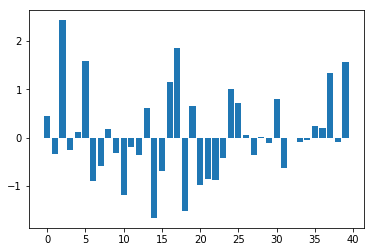

In [2]:
n_points = 40
x_vals = np.arange(n_points)
y_vals = np.random.normal(size=n_points)
plt.bar(x_vals, y_vals)

### <font color="blue">1.2 The Gaussian Kernel</font>

We present **kernel smoothing** below. A kernel is merely a function that 
can average points in the neighborhood of a target point.  Consider the 
**Gaussian kernel** shown in plot of the next cell. It is the density 
function of a standard normal random variable ($\mu = 0$, $\sigma = 1$). 
We denote its value at point $x$ by $\phi(x)$,  
  
$$
   \phi(x) = \frac{1}{\sqrt{2 \pi}} exp{-\frac{x^2}{2}}, \quad \text{ for } -\infty < x < \infty.
$$

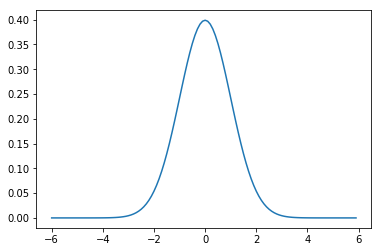

In [3]:
phi = stats.norm.pdf
x = np.arange(-6, 6, 0.1) # x from -6 to 6 in steps of 0.1
y = phi(x) # = 1 / np.sqrt(2 * np.pi) * np.exp(-x ** 2 / 2.)
plt.plot(x, y)

Suppose that the only nearby points are at -0.5, 0.5 and 1.0 and have 
values 4, 2 and 6 respectively. Then the standard normal kernel $\phi(x)$ 
forms a "smooth" weighted average of these points at $0$ (call it $h(0)$) 
as follows:

<center>$h(0) = \frac{\phi(-0.5) \cdot 4 \, + \, \phi(0.5) \cdot 2 \, + \, \phi(1.0) \cdot 6}{\phi(-0.5) \, + \, \phi(0.5) \, + \, \phi(1.0)} = 3.7673$</center>

This type of weighted average is called the **Nadaraya-Watson Estimator**. ([Derivation of the N-W Estimator](http://www.maths.manchester.ac.uk/~peterf/MATH38011/NPR%20N-W%20Estimator.pdf))  
  
For a Python calculation of h(0), see the next cell, which uses the 
*scipy.stats.norm* function for $\phi$.

In [4]:
h = round((phi(-0.5)*4 + phi(0.5)*2 + phi(1)*6)/(phi(-0.5) + phi(0.5) + phi(1)),4)
h

3.7673

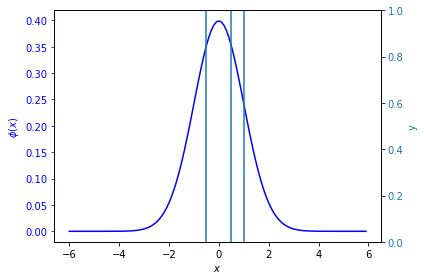

In [5]:
x = np.arange(-6, 6, 0.1) # x from -6 to 6 in steps of 0.1
y = stats.norm.pdf(x)
y = phi(x)

fig, ax1 = plt.subplots()
ax1.plot(x, y, 'b-')
ax1.set_xlabel(r'$x$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'$\phi(x)$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('y', color=color)  # we already handled the x-label with ax1
ax2.axvline(x=-0.5, ymin=0, ymax=4)
ax2.axvline(x= 0.5, ymin=0, ymax=2)
ax2.axvline(x= 1.0, ymin=0, ymax=6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Although statistics defines normal distributions centered at $0$ using 
units of standard deviation, investigators doing smoothing (engineers, 
astronomers, data scientists) have a more directly useful parameterization.
They describe a Gaussian using **Full Width at Half Maximum (FWHM)**.

**FWHM** is the width of the kernel at half of the maximum of the
height of the Gaussian. Thus, for the standard Gaussian above, the
maximum height is $\sim0.4$.  The width $x$ of the kernel at $\phi(x) = 0.2$ 
FWHM. Since $\phi(-1.175) = \phi(1.175) = 0.2$,  
  
  
<center>FWHM $ \sim 1.175 - (-1.175) = 2.35$.</center>  
  
Python functions that convert sigma to FWHM (sigma2fwhm) and vice versa 
(fwhm2signa) are defined in the  next cell.

In [6]:
def sigma2fwhm(sigma):
    return sigma * np.sqrt(8 * np.log(2))

def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

Using the function *sigma2fwhm* validates the calculation done previously.

In [7]:
round(sigma2fwhm(1),4)

2.3548

# Smoothing with the kernel

The basic process of smoothing is very simple. We proceed through the
data point by point. For each data point we generate a "smoothed" value 
obtained by averaging values of nearby data points. **Gaussian smoothing** 
refers to the process of using the Gaussian kernel in this process.

To generate an array of Gaussian smoothing weights for a smoothed value at 
the 14th value of our example data set, we use the Gaussian kernel with 
FWHM = 4 and center the kernel on the fourteenth value by subtracting from 
all other x_val points the number 13 (vecause of Python 0 indexing). A plot 
of the result is created by the next cell:

<Container object of 40 artists>

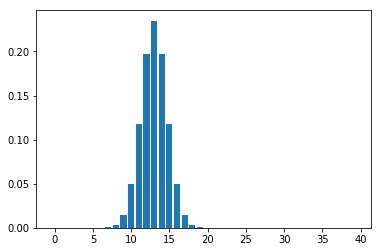

In [8]:
FWHM = 4
sigma = fwhm2sigma(FWHM)
x_position = 13 # 14th point
kernel_at_pos = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
kernel_at_pos = kernel_at_pos / sum(kernel_at_pos)
plt.bar(x_vals, kernel_at_pos)

In fact the Gaussian values for the 10th through 19th data points are:

In [9]:
kernel_at_pos[9:18]

array([0.01467871, 0.04937309, 0.11742966, 0.19749236, 0.23485932,
       0.19749236, 0.11742966, 0.04937309, 0.01467871])

and the data values for the same points are:

In [10]:
y_vals[9:18]

array([-0.32986996, -1.19276461, -0.20487651, -0.35882895,  0.6034716 ,
       -1.66478853, -0.70017904,  1.15139101,  1.85733101])

Ignoring points outside this range, which have very small weights, 
the smoothed value is the inner product of kernel weights (*kernel_at_pos*) 
and values (*y_vals*) divided by the sum of weights. This gives

In [11]:
y_by_weight = y_vals * kernel_at_pos # element-wise multiplication
new_val = sum(y_by_weight)
new_val

-0.3479685901184573

We store this new smoothed value for future use, and move on, to x = 14,
and repeat the process, with the Gaussian kernel now centered over 14.  If we
do this for each point, we eventually get the smoothed version of our original
data. Here is a very inefficient but simple way of doing this:

<Container object of 40 artists>

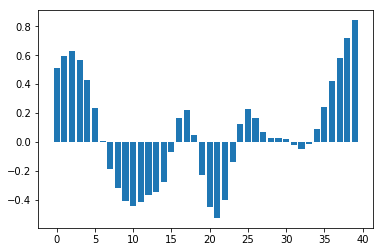

In [12]:
# Create an array of zeros in the same shape as y_vals.
smoothed_vals = np.zeros(y_vals.shape)

# Iterate over all x_vals and do a smoothing at each. 
# Then store the result in array "smoothed_vals"
FWHM = 4
sigma = fwhm2sigma(FWHM)
phi = stats.norm(0,sigma)
for x_position in x_vals:
    kernel = phi.pdf(x_vals - x_position)
    kernel = kernel / sum(kernel)
    smoothed_vals[x_position] = sum(y_vals * kernel)
    
# Plot the smoothed values
plt.bar(x_vals, smoothed_vals)

Notice that we show the smoothed values at each point 0, 1, ,,, 40. Butwe could have just as well interpolated at non-integer points. Since the Nadaraya-Watson estimator is continuous, a continuous (even differentiable) curve would result.

# Signal Processing

Scientists and engineers get exposed to signal processing in their training, whereas many data scientists do not. But the ideas and methods from signal processing are commonly used by data scientists. One such example is smoothing, the topic of this introduction. For more information on signal processing in data science, see
[Blog on Signal Processing and Data Science](https://www.datasciencecentral.com/profiles/blogs/machine-learning-with-signal-processing-techniques).

# Other kernels

Of course, we could have used any shape for the kernel - such as a
square wave. A square wave kernel with sum set to one would would have the
effect of replacing each data point with the mean of a symmetric, equally 
weighted average of neighboring points.

# Smoothing as convolution

Smoothing can also be implemented and understood as *convolution* - see
[Smoothing as convolution](https://matthew-brett.github.io/teaching/smoothing_as_convolution.html) for an explanation.

# Smoothing in 2D

Smoothing in two dimensions follows simply from smoothing in one
dimension. This time the Gaussian kernel is not a curve, but a "hill":

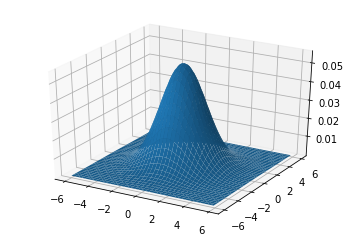

In [13]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dx = 0.1
dy = 0.1
x = np.arange(-6, 6, dx)
y = np.arange(-6, 6, dy)
x2d, y2d = np.meshgrid(x, y)
kernel_2d = np.exp(-(x2d ** 2 + y2d ** 2) / (2 * sigma ** 2))
kernel_2d = kernel_2d / (2 * np.pi * sigma ** 2) # unit integral
ax.plot_surface(x2d, y2d, kernel_2d)

Analogous to the 1-dimensional case, this kernel can be centered at any 
point of the 2D plane, and smoothed can be calculated. Ths 
get the equivalent kernel values for each point on the plane.  Here is a 2D
Gaussian kernel centered at point (10, 10) on a size (20, 20) plane.  See the
page source for the code to make the figure:

<img src="images/smoothing_intro-13.png">

We then proceed as before, multiplying the values of the kernel (as shown in
the figure above) by the data in the image, to get the smoothed value for that
point, and doing the same for every point on the image.

The procedure is the same for 3D data, except the kernel is rather more
difficult to visualize, being something like a sphere with edges that fade
out, as the cone fades out at the edges in the 2D case.

In fact, it turns out that we don’t have to generate these 2D and 3D versions
of the kernel for the computations, because we can get the same result from
applying a one dimensional smooth sequentially in the 2 or 3 dimensions. Thus,
for 2 dimensions, we could first smooth in the x direction, and then smooth
the x-smoothed data, in the y direction, This gives the same output as
applying the 2D kernel. (Why?)

# Why smooth?

The primary reason for smoothing is to increase signal to noise.  Smoothing
increases signal to noise by the matched filter theorem [Wikipedia: Matched Filter](https://en.wikipedia.org/wiki/Matched_filter). This theorem states
that the filter that will give optimum resolution of signal from noise is a
filter that is matched to the signal. In the case of smoothing, the filter is
the Gaussian kernel. Therefore, if we are expecting signal in our images that
is of Gaussian shape, and of FWHM of say 10mm, then this signal will best be
detected after we have smoothed our images with a 10mm FWHM Gaussian
filter.  
  
The next few images show the matched filter theorem in action. First we
can generate a simulated signal in a one dimensional set of data, by creating
a Gaussian with FWHM 8 pixels, centered over the 14th data point:

<Container object of 40 artists>

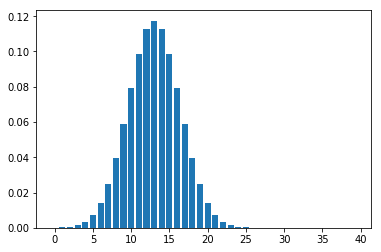

In [14]:
# Set the Gaussian kernal phi
FWHM = 8
sigma = fwhm2sigma(FWHM)
phi = stats.norm(0,sigma).pdf

# Calculate the Kernel weights
x_position = 13 # 14th point
sim_signal = phi(x_vals - x_position)

# Plot the values
plt.bar(x_vals, sim_signal)

Next, we add some Gaussian noise to this signal:

<Container object of 40 artists>

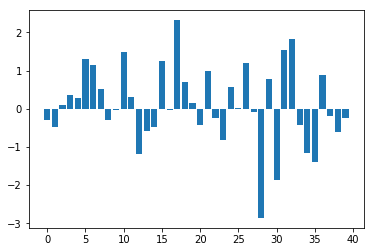

In [15]:
noise = np.random.normal(size=n_points)
sim_data = sim_signal + noise
plt.bar(x_vals, sim_data)

We then smooth with a matching 8 pixel FWHM filter:

<Container object of 40 artists>

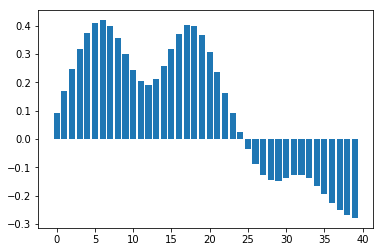

In [16]:
smoothed_sim_data = np.zeros(y_vals.shape)
for x_position in x_vals:
    kernel = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
    kernel = kernel / sum(kernel)
    smoothed_sim_data[x_position] = sum(sim_data * kernel)
plt.bar(x_vals, smoothed_sim_data)

and recover our signal, albeit somewhat distorted, from the noisy data.

## <font color="blue">Part II: Scatterplot Smoothing in Python</font>

In [17]:
import math
import numpy as np
import pandas.tseries as tseries
import pandas as pd
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import norm# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
import skmisc
import statsmodels.nonparametric as nonp

%matplotlib inline

/home/smoffitt/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [18]:
# Test dataset for smoothing
E_21_63 = pd.read_csv("data/Data-E2-21-63-Prcomp.csv")
x = E_21_63["x"]
y = E_21_63["y"]

### <font color="blue">Loess</font>

*Loess* in my experience is an excellent general purpose smoother that uses a **tri-cubic weight function** to form a weighted least squares regression over the range of the data. A major advantage of *loess* is that it requires the specification only of a *smoothing* parameter, and the *degree* of the polynomial used for local fitting.  

Source: [Wikipedia: Local Regression](https://en.wikipedia.org/wiki/Local_regression)

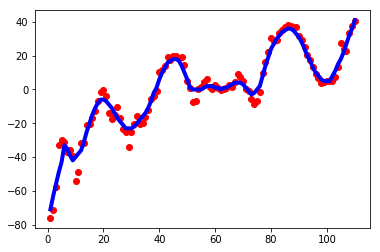

In [19]:
from loess.loess_1d import loess_1d

xout, yout, weights = loess_1d(np.array(x), np.array(y), frac=0.1)

w = weights < 0.34  # identify outliers
plt.clf()
plt.plot(x, y, 'ro', label='Noisy')
plt.plot(xout, yout, 'b', linewidth=4, label='LOESS')

### <font color="blue">Lowess</font>

*Lowess* is an earlier robust smoother that was later refined as *loess*. For the basic method in its calculation, see   
  
[Lowess for Geographic Data](https://www.ime.unicamp.br/~dias/loess.pdf).

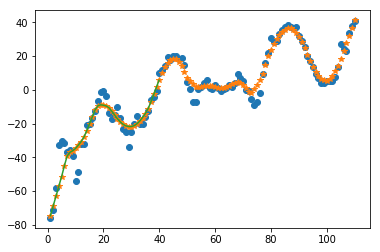

In [20]:
from scipy.interpolate import interp1d
import statsmodels.api as sm

# introduce some floats in our x-values
x = E_21_63["x"]
y = E_21_63["y"]

# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(y, x, frac=.1)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = [i/10. for i in range(400)]

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)


plt.plot(x, y, 'o')
plt.plot(lowess_x, lowess_y, '*')
plt.plot(xnew, ynew, '-')
plt.show()

### <font color="blue">The Savitsky-Golay Filter</font>

The *Savitsky-Golay Filter* was first developed in 1964 using convolutions of neighboring points to form a smoothed value at the central point. The calculation is involved. See  
  
[The Savitsky-Golay Filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter).

In [21]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

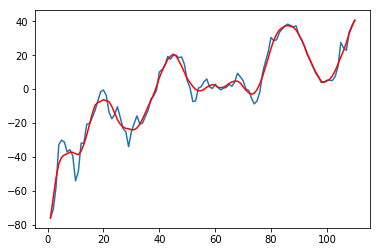

In [22]:
import numpy as np
import matplotlib.pyplot as plt

yhat = savitzky_golay(np.array(y), 15, 2) # window size 51, polynomial order 3

plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.show()

### <font color="blue">Moving Average Box</font>

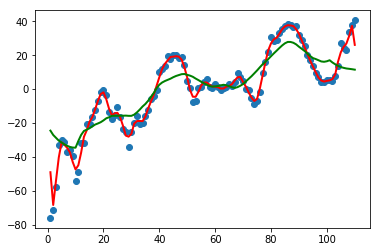

In [23]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(x, y,'o')
plt.plot(x, smooth(y,3), 'r-', lw=2)
plt.plot(x, smooth(y,19), 'g-', lw=2)

### <font color="blue">KernReg</font>

Kernel regression is a general algorithm for performing regression using kernels. For an excellent slide show, see

[smoothers](https://robjhyndman.com/etc5410/kernreg.pdf)

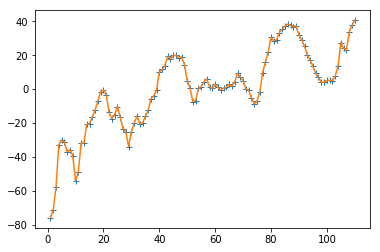

In [24]:
from statsmodels.nonparametric.kernel_regression import KernelReg

# The third parameter specifies the type of the variable x;
# 'c' stands for continuous
kr = KernelReg(np.array(y),np.array(x),'c')
plt.plot(x, y, '+')
y_pred, y_std = kr.fit(np.array(x))
plt.plot(x, y_pred)
plt.show()

### <font color="blue">Natural Smoothing Splines</font>

Smoothing splines are a popular type of smoother. The idea behind them is to fit a piecewise smooth polynomial joined at **knot points** where the polynomials have the same first few derivatives in such a fashion to minimize the error sum of squares. The details of the method are considerable: to see how their calculation can be reduced to the solution to a constrained least squares problem, see [Smothing Splines](http://www.stat.cmu.edu/~ryantibs/advmethods/notes/smoothspline.pdf).

In [25]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

In the call to the *get_natural_cubic_spline_model* function the first two arguments are $x$ and $y$, the next two the minimum and maximum values of $x$ and *n_knots*, which can be used to control the smoothness. Fewer knots may lead to a smoother function that **underfits** and more knots to one that **overfits**.

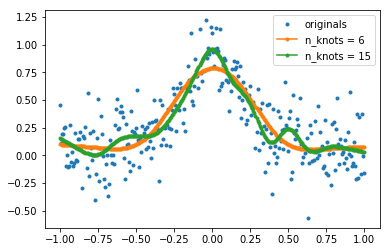

In [26]:
from matplotlib import pyplot as plt
import numpy as np

def func(x):
    return 1/(1+25*x**2)

# make example data
x = np.linspace(-1,1,300)
y = func(x) + np.random.normal(0, 0.2, len(x))

# The number of knots can be used to control the amount of smoothness
model_6 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=6)
model_15 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=15)
y_est_6 = model_6.predict(x)
y_est_15 = model_15.predict(x)


plt.plot(x, y, ls='', marker='.', label='originals')
plt.plot(x, y_est_6, marker='.', label='n_knots = 6')
plt.plot(x, y_est_15, marker='.', label='n_knots = 15')
plt.legend(); plt.show()

### <font color="blue">Loess 2D Example</font>

*Loess 2D* is the same basic algorithm as *Loess*, but adapted to spatial (2D) data. The demonstration below shows that it can denoise an image quite effectively.

See [Wikipedia: Local Regression](https://en.wikipedia.org/wiki/Local_regression)

0.309448999999999


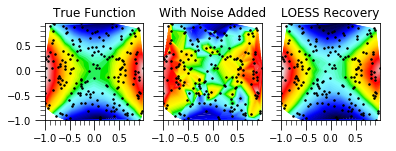

In [27]:
#### loess 2d example

#!/usr/bin/env python
##############################################################################
#
# Usage example for the procedure loess_2d
#
# MODIFICATION HISTORY:
#   V1.0.0: Written by Michele Cappellari, Oxford 26 February 2014
#   V1.0.1: Changed imports for loess and plotbin as packages. 
#       Removed overlap of axes labels. MC, Oxford, 17 April 2018    
#
##############################################################################

import numpy as np
import matplotlib.pyplot as plt

from time import clock

from loess.loess_2d import loess_2d
from plotbin.plot_velfield import plot_velfield

def test_loess_2d():
    """
    Usage example for loess_2d

    """
    n = 200
    x = np.random.uniform(-1,1,n)
    y = np.random.uniform(-1,1,n)
    z = x**2 - y**2
    sigz = 0.2
    zran = np.random.normal(z, sigz)

    t = clock()
    zout, wout = loess_2d(x, y, zran)
    print(clock() - t)

    plt.clf()
    plt.subplot(131)
    plot_velfield(x, y, z)
    plt.title("True Function")

    plt.subplot(132)
    plot_velfield(x, y, zran)
    plt.title("With Noise Added")
    plt.tick_params(labelleft=False)

    plt.subplot(133)
    plot_velfield(x, y, zout)
    plt.title("LOESS Recovery")
    plt.tick_params(labelleft=False)
    plt.pause(1)

#------------------------------------------------------------------------

if __name__ == '__main__':
    test_loess_2d()

## <font color="blue">3: Boundary Bias</font>

A feature that afflicts all smoothers is **boundary bias**. In most of the
common smoothing methods, including the ones we present below, smooth-
ing is accomplished by some form of “averaging” of sample points in a 
neighborhood of the target point. But this causes loss of smoothing accuracy
and precision near a boundary if those neighborhoods are truncated by the
boundary. For example, in a univariate smoother that uses the nearest 10
sample points below and the nearest 10 above, then averages them somehow,
near the left and right boundaries (the minimum and maximum of sample
values, respectively) there won’t be 10 sample points on both sides, thus
destroying the balanced averaging enjoyed by interior points. Of course,
other methods also have this problem, e.g. simple linear regression in which
widening of the confidence bands occurs as one approaches either boundary.

A particular manifestation of this bias occurs if the data are a *time series*,
that is, a data set of values ogserved sequentially in time. Such data are 
ubiquitous in the financial markets, for example, in which one wishes to predict 
the future course of stock prices. But the smoothing methods 
considered in this section are all two sided, meaning that they form averages 
at any time using both past and **future** values. For time series, anyway, 
smoothing can have value, just not predictive value.


## <font color="blue">4. Summary</font>

In this section we investigated several smoothers:

1. Gaussian kernel smoothers
2. Loess_1d
3. Lowess
4. Savitsky-Golay Filter
5. Moving Average Box
6. KernReg
7. Natural Smoothing Splines
8. Loess_2d  
  
For definitions of the exact calculation for each 
of these, see the Python documentation.  
  
Each of these smoothers operates on the principle 
of estimating values at particular points by taking 
a weighted average of nearby points.

All such smoothers suffer from **boundary bias**, 
the degredation of smoothed values near boundaries 
due to the unavailability of points on "the other 
side of the boundary."